###Import Libraries

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import cv2

### Using Inceptionv3 pre-trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

local_weights_file='/content/drive/My Drive/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 111, 111, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 111, 111, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


## Adding Custom Layers

In [ ]:
#Using RMS prop
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
# Adding a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
base_dir='/content/drive/My Drive/data/'

# Directory with the training and testing examples
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
#Directories for training images
train_dm_dir = os.path.join(train_dir,'downey')
train_pm_dir = os.path.join(train_dir,'powderly')
train_s_dir = os.path.join(train_dir,'septoria')

#Directories for Validation images
val_dm_dir = os.path.join(validation_dir,'downy mildew')
val_pm_dir = os.path.join(validation_dir,'powdery mildew')
val_s_dir = os.path.join(validation_dir,'septoria')

In [ ]:
print('total downy mildew in training: ', len(os.listdir(train_dm_dir)))
print('total powdery_mildew in training: ', len(os.listdir(train_pm_dir)))
print('total septoria in training: ', len(os.listdir(train_s_dir)))

total downy mildew in training:  336
total powdery_mildew in training:  393
total septoria in training:  276


In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
# Adding data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (224,224))     

validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224,224)

Found 1004 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
1004


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = train_generator.samples//32,
            epochs = 150,
            validation_steps = validation_generator.samples//32,
            verbose = 1)

Epoch 1/150
31/31 [==============================] - 164s 5s/step - loss: 1.0336 - accuracy: 0.5237 - val_loss: 0.6290 - val_accuracy: 0.7188
Epoch 2/150
31/31 [==============================] - 130s 4s/step - loss: 0.8918 - accuracy: 0.6091 - val_loss: 0.6054 - val_accuracy: 0.7500
Epoch 3/150
31/31 [==============================] - 129s 4s/step - loss: 0.8009 - accuracy: 0.6440 - val_loss: 0.6146 - val_accuracy: 0.7188
Epoch 4/150
31/31 [==============================] - 129s 4s/step - loss: 0.6999 - accuracy: 0.6975 - val_loss: 0.6008 - val_accuracy: 0.7188
Epoch 5/150
31/31 [==============================] - 134s 4s/step - loss: 0.6866 - accuracy: 0.7016 - val_loss: 0.5885 - val_accuracy: 0.8125
Epoch 6/150
31/31 [==============================] - 129s 4s/step - loss: 0.7165 - accuracy: 0.6965 - val_loss: 0.5011 - val_accuracy: 0.8125
Epoch 7/150
31/31 [==============================] - 130s 4s/step - loss: 0.6539 - accuracy: 0.7119 - val_loss: 0.7924 - val_accuracy: 0.6562
Epoch 

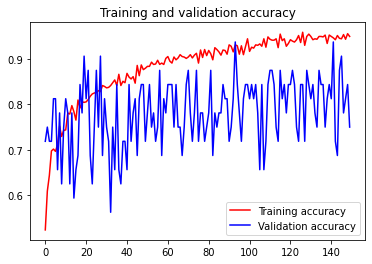

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Saving downey1.jpg to downey1 (1).jpg
Saving powderly1.jpg to powderly1 (1).jpg
Saving powderly2.jpg to powderly2 (1).jpg
Saving septoria (2).jpg to septoria (2) (1).jpg
Saving septoria.jpg to septoria (1).jpg
Saving Tampa-Tree-Care-Powdery-Downy-Mildew.jpg to Tampa-Tree-Care-Powdery-Downy-Mildew.jpg
Saving TopicalviewofcucumberdownymildewIMG_2508.jpg to TopicalviewofcucumberdownymildewIMG_2508.jpg


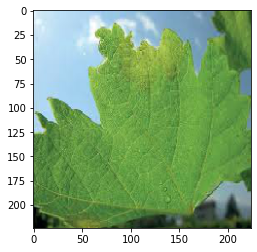

Powdery Mildew Disease Detected


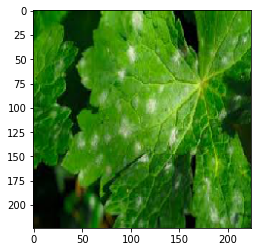

Powdery Mildew Disease Detected


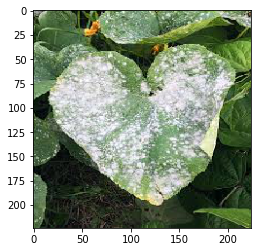

Powdery Mildew Disease Detected


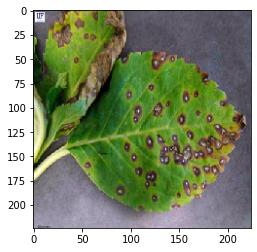

Powdery Mildew Disease Detected


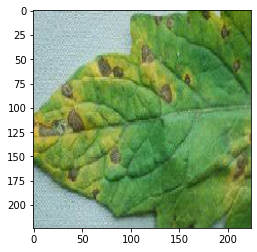

Powdery Mildew Disease Detected


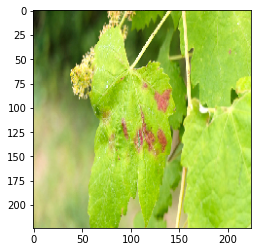

Powdery Mildew Disease Detected


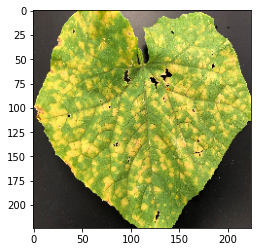

Powdery Mildew Disease Detected


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  plt.imshow(img)

  plt.show()

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  for i in classes:
    if classes[0][0]==1:
      print('Downy Mildew Disease Detected')
    elif classes[0][1]==1:
      print('Powdery Mildew Disease Detected')
    elif classes[0][2]==1:
      print('Septoria Disease Detected')

#Model 2

In [ ]:
#Using RMS prop
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
# Adding a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

NameError: ignored

In [ ]:
# Adding data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'categorical', 
                                                    target_size = (224,224))     

validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224,224)

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = train_generator.samples//32,
            epochs = 100,
            validation_steps = validation_generator.samples//32,
            verbose = 1)